# 🏀 バスケットボール選手判別チャレンジ - EDA

このノートブックでは、データの理解を深めるための探索的データ分析を行います。

## 目次
1. データ読み込み
2. メタデータの基本統計
3. 画像ファイルの確認
4. 選手IDの分布
5. 時系列分析（クオーター、セッション、フレーム）
6. Bounding Boxの分析
7. 画角（angle）の比較
8. 画像の可視化
9. テストデータの特徴
10. まとめと考察

## 1. データ読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import matplotlib_fontja

import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
# plt.rcParams['font.family'] = ['Noto Sans CJK JP', 'Yu Gothic', 'Hiragino Sans', 'MS Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

print("ライブラリの読み込み完了")


ライブラリの読み込み完了


In [2]:
# パス設定
DATA_DIR = Path("../data/raw")
IMAGE_DIR = DATA_DIR / "images"
IMAGE_TEST = DATA_DIR / "crops"

In [4]:
# メタデータ読み込み
train_meta = pd.read_csv(DATA_DIR / "train_meta.csv")
test_meta = pd.read_csv(DATA_DIR / "test_meta.csv")

print("データ読み込み完了")
print(f"train_meta: {train_meta.shape}")
print(f"test_meta: {test_meta.shape}")

データ読み込み完了
train_meta: (24920, 9)
test_meta: (9223, 9)


## 2. メタデータの基本統計

In [5]:
# 学習データの基本情報
print("=" * 60)
print("📊 学習データ（train_meta）の基本情報")
print("=" * 60)
print(train_meta.info())
print("\n最初の5行:")
display(train_meta.head())

print("\n基本統計量:")
display(train_meta.describe())

📊 学習データ（train_meta）の基本情報
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24920 entries, 0 to 24919
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   quarter   24920 non-null  object
 1   angle     24920 non-null  object
 2   session   24920 non-null  int64 
 3   frame     24920 non-null  int64 
 4   x         24920 non-null  int64 
 5   y         24920 non-null  int64 
 6   w         24920 non-null  int64 
 7   h         24920 non-null  int64 
 8   label_id  24920 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.7+ MB
None

最初の5行:


,quarter,angle,session,frame,x,y,w,h,label_id
0,Q1-000,side,0,1,1526,961,60,151,0
1,Q1-000,side,0,1,1657,980,55,161,6
2,Q1-000,side,0,1,1786,850,61,122,2
3,Q1-000,side,0,1,1789,883,52,146,1
4,Q1-000,side,0,1,1864,925,41,166,7



基本統計量:


,session,frame,x,y,w,h,label_id
count,24920.0,24920.000000,24920.000000,24920.000000,24920.000000,24920.000000,24920.000000
mean,0.0,22.443780,1829.018981,962.244141,110.022151,126.292937,5.368379
std,0.0,12.935571,824.767174,257.460364,38.064008,28.324650,3.000851
min,0.0,1.000000,0.000000,0.000000,33.000000,38.000000,0.000000
25%,0.0,11.000000,1099.000000,882.000000,76.000000,101.000000,3.000000
50%,0.0,22.000000,1857.000000,967.000000,105.000000,126.000000,5.000000
75%,0.0,33.000000,2571.000000,1048.000000,141.000000,150.000000,8.000000
max,0.0,46.000000,3565.000000,2087.000000,293.000000,277.000000,10.000000


In [7]:
# テストデータの基本情報
print("=" * 60)
print("📊 テストデータ（test_meta）の基本情報")
print("=" * 60)
print(test_meta.info())
print("\n最初の5行:")
display(test_meta.head())

print("\n基本統計量:")
display(test_meta.describe())

📊 テストデータ（test_meta）の基本情報
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9223 entries, 0 to 9222
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   x                 9223 non-null   int64 
 1   y                 9223 non-null   int64 
 2   w                 9223 non-null   int64 
 3   h                 9223 non-null   int64 
 4   quarter           9223 non-null   object
 5   session_no        9223 non-null   int64 
 6   frame_in_session  9223 non-null   int64 
 7   angle             9223 non-null   object
 8   rel_path          9223 non-null   object
dtypes: int64(6), object(3)
memory usage: 648.6+ KB
None

最初の5行:


,x,y,w,h,quarter,session_no,frame_in_session,angle,rel_path
0,1366,699,137,108,Q4-000,1,0,top,crops/Q4-000/sess_0001/top/Q4-000__sess0001__f...
1,1404,931,116,91,Q4-000,1,0,top,crops/Q4-000/sess_0001/top/Q4-000__sess0001__a...
2,2089,1520,119,110,Q4-000,1,0,top,crops/Q4-000/sess_0001/top/Q4-000__sess0001__0...
3,2532,274,137,128,Q4-000,1,0,top,crops/Q4-000/sess_0001/top/Q4-000__sess0001__e...
4,2534,1241,115,135,Q4-000,1,0,top,crops/Q4-000/sess_0001/top/Q4-000__sess0001__f...



基本統計量:


,x,y,w,h,session_no,frame_in_session
count,9223.000000,9223.000000,9223.000000,9223.000000,9223.000000,9223.000000
mean,1842.797354,931.404424,105.656077,147.955329,3.448661,2.485851
std,713.506916,200.505989,31.509275,33.201118,1.687062,1.789082
min,64.000000,0.000000,45.000000,16.000000,1.000000,0.000000
25%,1228.000000,862.000000,81.000000,118.000000,2.000000,1.000000
50%,1712.000000,919.000000,97.000000,151.000000,3.000000,2.000000
75%,2527.000000,995.000000,129.000000,172.000000,5.000000,4.000000
max,3772.000000,1850.000000,235.000000,293.000000,7.000000,6.000000


## 3. 画像ファイルの確認

In [8]:
# 画像ファイルの確認
if IMAGE_DIR.exists():
    image_files = list(IMAGE_DIR.glob("*.jpg"))
    print(f"📸 画像ファイル数: {len(image_files)}")
    
    # ファイル名の例を表示
    print("\n画像ファイル名の例:")
    for i, img_path in enumerate(image_files[:5]):
        print(f"  {i+1}. {img_path.name}")
    
    # ファイル名のパース例
    print("\nファイル名の構造:")
    sample_name = image_files[0].stem
    parts = sample_name.split("__")
    print(f"  サンプル: {sample_name}")
    print(f"  クオーター: {parts[0]}")
    print(f"  画角: {parts[1]}")
    print(f"  セッション: {parts[2]}")
    print(f"  フレーム: {parts[3]}")
else:
    print(f"⚠️ 画像ディレクトリが見つかりません: {IMAGE_DIR}")

📸 画像ファイル数: 3394

画像ファイル名の例:
  1. Q1-002__side__00__01.jpg
  2. Q2-011__top__00__42.jpg
  3. Q2-016__top__00__29.jpg
  4. Q4-006__top__00__10.jpg
  5. Q2-005__side__00__10.jpg

ファイル名の構造:
  サンプル: Q1-002__side__00__01
  クオーター: Q1-002
  画角: side
  セッション: 00
  フレーム: 01


In [19]:
# 画像ファイルの確認
if IMAGE_TEST.exists():
    image_files_test = list(IMAGE_TEST.glob("**/*.jpg"))
    print(f"📸 画像ファイル数: {len(image_files)}")
    
    # ファイル名の例を表示
    print("\n画像ファイル名の例:")
    for i, img_path in enumerate(image_files_test[:5]):
        print(f"  {i+1}. {img_path.name}")
    
    # ファイル名のパース例
    print("\nファイル名の構造:")
    sample_name = image_files_test[0].stem
    parts = sample_name.split("__")
    print(f"  サンプル: {sample_name}")
    print(f"  クオーター: {parts[0]}")
    print(f"  画角: {str(image_files_test[0]).split("/")[-2]}")
    print(f"  セッション: {parts[1]}")
else:
    print(f"⚠️ 画像ディレクトリが見つかりません: {IMAGE_DIR}")

📸 画像ファイル数: 3394

画像ファイル名の例:
  1. Q4-012__sess0003__eb7949fc23384061a140e535046e4373.jpg
  2. Q4-012__sess0003__d5d6483fc0df498dbb97647f80e5f4a6.jpg
  3. Q4-012__sess0003__6f652a0465af4860b64205d939b8e54f.jpg
  4. Q4-012__sess0003__b13dcdd82d4a43abb9914b41a260b467.jpg
  5. Q4-012__sess0003__b91bf1facf6e4487b876e1c3281be987.jpg

ファイル名の構造:
  サンプル: Q4-012__sess0003__eb7949fc23384061a140e535046e4373
  クオーター: Q4-012
  画角: side
  セッション: sess0003


In [16]:

image_files_test[0]

PosixPath('../data/raw/crops/Q4-012/sess_0003/side/Q4-012__sess0003__eb7949fc23384061a140e535046e4373.jpg')

# test_meta.csvの解析

In [21]:
# 列名を揃える（後で使いやすい）
test_meta["session"] = test_meta["session_no"].astype(int)
test_meta["frame"] = test_meta["frame_in_session"].astype(int)

# 1フレーム(quarter, session, frame, angle)あたりのbbox数
cnt = (
    test_meta.groupby(["quarter", "session", "frame", "angle"])
        .size()
        .rename("n_bbox")
        .reset_index()
)

print(cnt["n_bbox"].describe())
print(cnt["n_bbox"].value_counts().head(30))

# 参考：angle別の分布
print("\nBy angle")
print(cnt.groupby("angle")["n_bbox"].describe())

count    833.000000
mean      11.072029
std        1.267985
min        8.000000
25%       10.000000
50%       11.000000
75%       12.000000
max       14.000000
Name: n_bbox, dtype: float64
n_bbox
11    247
10    197
12    197
13     81
9      75
14     26
8      10
Name: count, dtype: int64

By angle
       count       mean       std  min   25%   50%   75%   max
angle                                                         
side   555.0  11.016216  1.287859  8.0  10.0  11.0  12.0  14.0
top    278.0  11.183453  1.222006  8.0  10.0  11.0  12.0  14.0


In [22]:
# 少ない順（トップ10）
print("\nSmallest frames:")
print(cnt.sort_values("n_bbox").head(10))

# 多い順（トップ10）
print("\nLargest frames:")
print(cnt.sort_values("n_bbox", ascending=False).head(10))


Smallest frames:
    quarter  session  frame angle  n_bbox
615  Q4-015        5      2  side       8
502  Q4-012        3      6  side       8
798  Q4-019        4      1  side       8
401  Q4-009        3      6  side       8
440  Q4-010        4      4  side       8
82   Q4-002        3      0  side       8
601  Q4-015        2      6  side       8
634  Q4-016        1      4   top       8
751  Q4-018        4      2  side       8
331  Q4-007        5      0   top       8

Largest frames:
    quarter  session  frame angle  n_bbox
84   Q4-002        3      2  side      14
404  Q4-009        4      2  side      14
787  Q4-019        3      0   top      14
24   Q4-000        5      0   top      14
701  Q4-017        2      0  side      14
121  Q4-003        3      2   top      14
544  Q4-013        4      5   top      14
380  Q4-008        6      1  side      14
63   Q4-001        5      4  side      14
62   Q4-001        5      3  side      14


In [24]:
test_meta[(test_meta["quarter"]=="Q4-002") & (test_meta["session"]==3) & (test_meta["frame"]==2)]

,x,y,w,h,quarter,session_no,frame_in_session,angle,rel_path,session,frame
939,906,890,104,127,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
940,914,896,89,165,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
941,926,870,105,128,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
942,933,921,84,173,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
943,940,839,76,139,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
944,988,929,130,159,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
945,1113,955,92,207,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
946,1144,1017,92,206,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
947,1405,919,78,156,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2
948,1438,848,60,135,Q4-002,3,2,side,crops/Q4-002/sess_0003/side/Q4-002__sess0003__...,3,2


n_images: 14


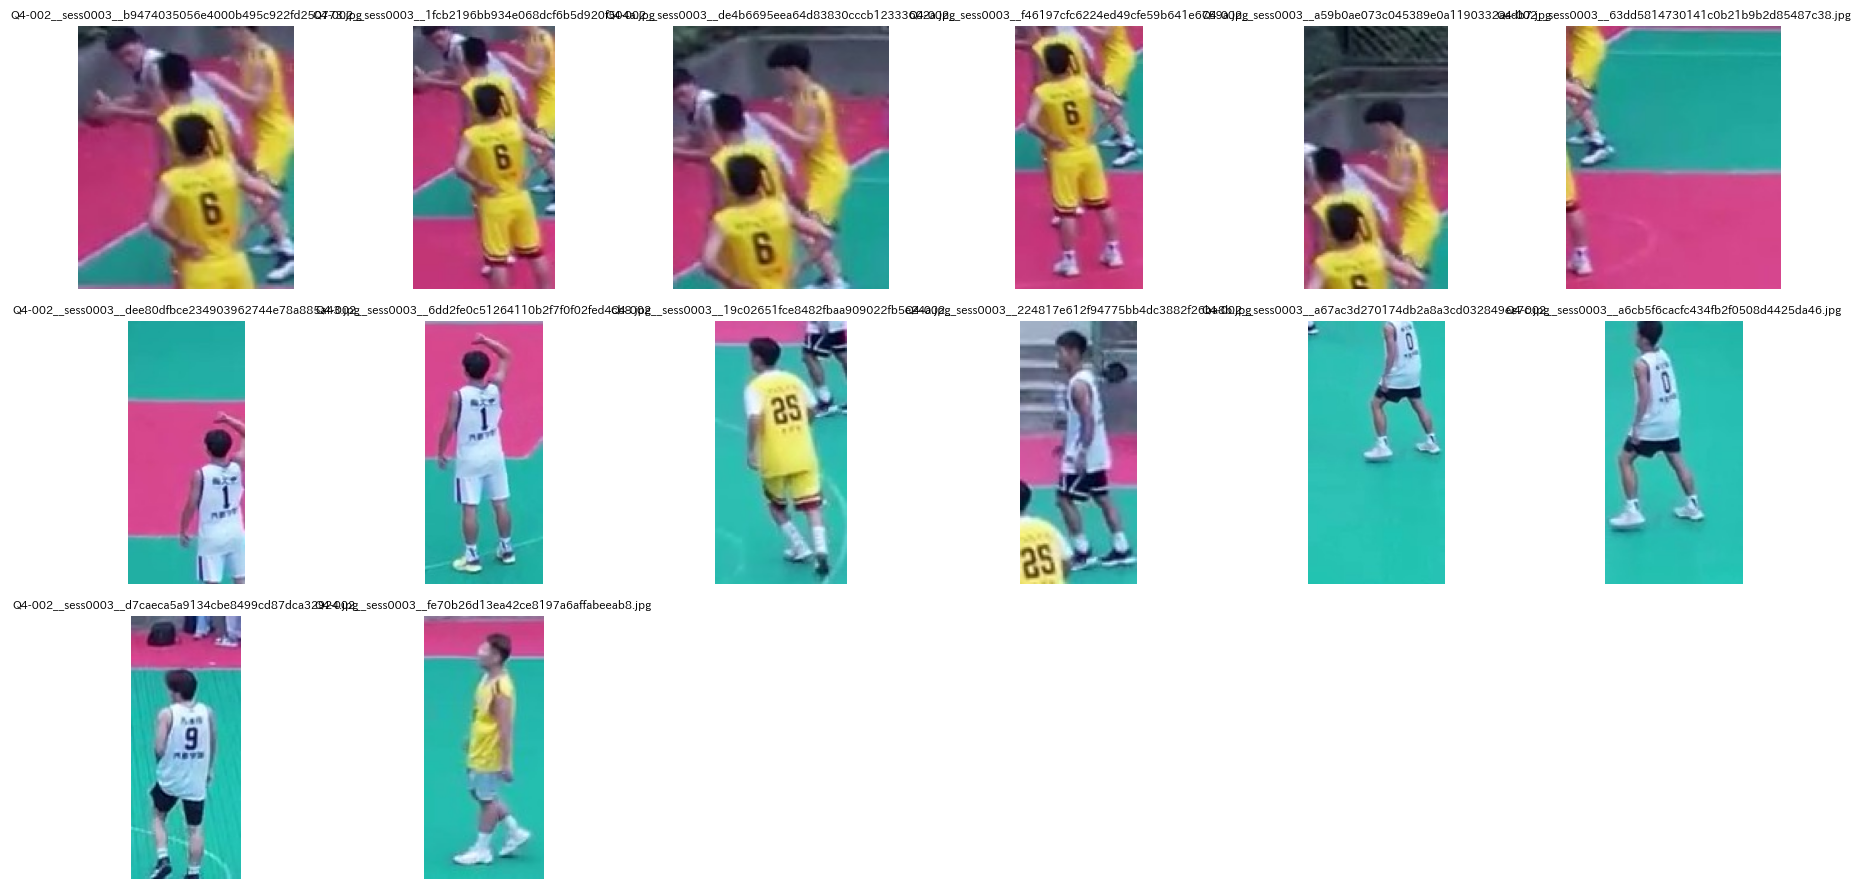

In [28]:
import math, cv2

sel = test_meta[
    (test_meta["quarter"] == "Q4-002") &
    (test_meta["session"] == 3) &
    (test_meta["frame"] == 2)
].copy()

paths = sel["rel_path"].tolist()
print("n_images:", len(paths))

ncols = 6
nrows = math.ceil(len(paths) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
axes = axes.ravel() if hasattr(axes, "ravel") else [axes]

for i, rel in enumerate(paths):
    p = DATA_DIR / rel
    img = cv2.imread(str(p))
    if img is None:
        axes[i].set_title(f"missing\n{p.name}", fontsize=8)
        axes[i].axis("off")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(p.name, fontsize=8)
    axes[i].axis("off")

# 余った枠を消す
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

n_images: 8


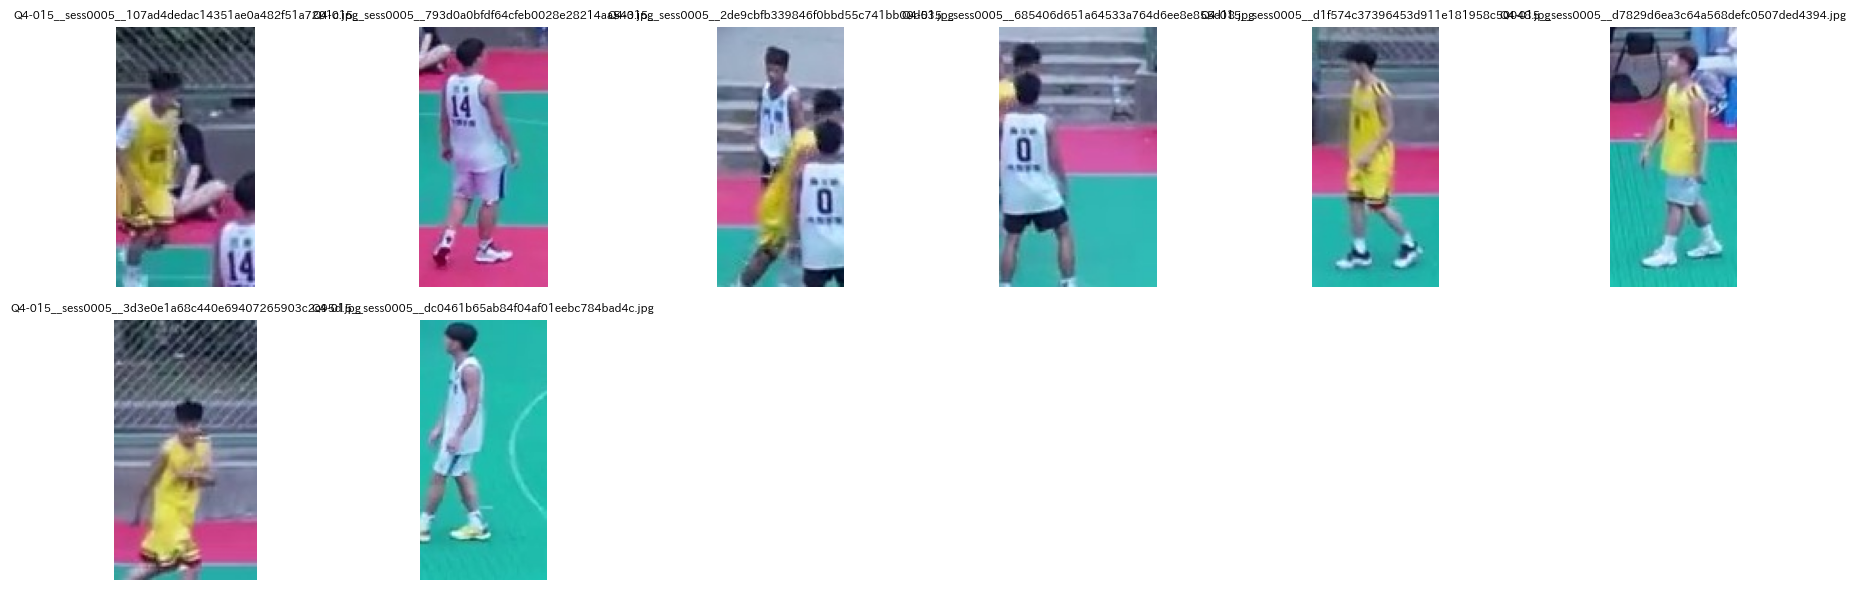

In [29]:
import math, cv2

sel = test_meta[
    (test_meta["quarter"] == "Q4-015") &
    (test_meta["session"] == 5) &
    (test_meta["frame"] == 2)
].copy()

paths = sel["rel_path"].tolist()
print("n_images:", len(paths))

ncols = 6
nrows = math.ceil(len(paths) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
axes = axes.ravel() if hasattr(axes, "ravel") else [axes]

for i, rel in enumerate(paths):
    p = DATA_DIR / rel
    img = cv2.imread(str(p))
    if img is None:
        axes[i].set_title(f"missing\n{p.name}", fontsize=8)
        axes[i].axis("off")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(p.name, fontsize=8)
    axes[i].axis("off")

# 余った枠を消す
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()